# Read evaluation and generate tables and bar plots
Goal: reproduce result summaries from the platform to integrate them in the paper.

In [1]:
from icdar24_maptext_analysis.loaders import check_for_missing_images, VALID_SUBSETS, VALID_TASKS, load_results, list_results 
from icdar24_maptext_analysis.paths import RELPATH_FILE_SUBMISSIONS_META
import pandas as pd

Quickly check we have all images from test sets available.

Note: generation of figures with images may be extracted to another notebook for clarity and to avoid the need to download image test sets for basic graph generation.

In [2]:
for subset in ("ign", ):  #VALID_SUBSETS:
    if len(missing_image := check_for_missing_images(subset)) > 0:
        print(f"Missing images in {subset}: {missing_image}")
        raise RuntimeError(f"Missing images in {subset}")

## Read metadata and filter content

Load the metadata file and set the submission id as index.

In [3]:
submissions_meta = pd.read_csv(RELPATH_FILE_SUBMISSIONS_META).set_index('ID')
submissions_meta

,Unnamed: 0,User,Date,Challenge,Task,Valid,Competition,Val. Set,Title,Filesize,Public,Eval.time,Results size
ID,,,,,,,,,,,,,
113398,93096,user_36250,2024-03-23 15:31:02,28,1,1,1,0,ds-lp,10318653,1,00:00:36,642.0
113413,93111,user_52424,2024-03-24 22:55:02,28,1,1,1,0,Test,278970683,1,00:00:44,321.0
113460,93158,user_36250,2024-03-26 06:24:55,28,4,1,1,0,DS-LP,14289896,1,00:26:18,467.0
113461,93159,user_36250,2024-03-26 06:26:21,28,3,1,1,0,DS-LP,14289896,1,00:25:14,459.0
113462,93160,user_36250,2024-03-26 06:27:32,28,2,1,1,0,DS-LP,14289896,1,00:03:56,792.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114581,94279,user_51343,2024-05-06 04:57:11,28,2,1,1,0,MapText Detection-Linking Strong Pipeline,165918784,1,00:22:04,792.0
114582,94280,user_51343,2024-05-06 05:00:51,28,3,1,1,0,MapText Detection and Recognition Strong Pipeline,154636953,1,00:22:05,910.0
114583,94281,user_51343,2024-05-06 05:16:27,28,4,1,1,0,MapText Detection-Recognition-Linking Strong P...,165918784,1,00:22:04,939.0


Based on a manual check, it looks like the following submissions can be deleted from our analysis as duplicates:

- Task 1: 114256, 114281, 114292
- Task 2: 114294, 114580
- Task 3: 114289, 114291, 114322
- Task 4: 114295, 114583, 114584

We believe all of them have Rumsey entries, but not all of them may have IGN entries.

In [4]:
duplicate_submission_ids_manual = [
    114256, 114281, 114292,  # task 1
    114294, 114580,  # task 2
    114289, 114291, 114322,  # task 3
    114295, 114583, 114584]  # task 4

Collect the set of submission ids for which evaluation is available.

In [5]:
available_results = []
for task_id in VALID_TASKS:
    for subset in VALID_SUBSETS:
        available_results.extend(list_results(task_id, subset))
available_results = set(int(x) for x in available_results)
len(available_results)

35

In [6]:
valid_submission_ids = available_results - set(duplicate_submission_ids_manual)
len(valid_submission_ids)

24

In [7]:
submissions_meta_ignored = submissions_meta.loc[~submissions_meta.index.isin(valid_submission_ids)]
submissions_meta_valid = submissions_meta.loc[submissions_meta.index.isin(valid_submission_ids)]
print(f"Total submissions: {len(submissions_meta)}, valid: {len(valid_submission_ids)}, discarded: {len(submissions_meta_ignored)}")

Total submissions: 63, valid: 24, discarded: 39


### Valid submissions to be included in the report

In [8]:
submissions_meta_valid

,Unnamed: 0,User,Date,Challenge,Task,Valid,Competition,Val. Set,Title,Filesize,Public,Eval.time,Results size
ID,,,,,,,,,,,,,
113460,93158,user_36250,2024-03-26 06:24:55,28,4,1,1,0,DS-LP,14289896,1,00:26:18,467.0
113461,93159,user_36250,2024-03-26 06:26:21,28,3,1,1,0,DS-LP,14289896,1,00:25:14,459.0
113462,93160,user_36250,2024-03-26 06:27:32,28,2,1,1,0,DS-LP,14289896,1,00:03:56,792.0
113464,93162,user_36250,2024-03-26 06:33:14,28,1,1,1,0,DS-LP,14289896,1,00:05:55,792.0
113478,93176,user_9,2024-03-26 16:11:30,28,1,1,1,0,Baseline TESTR Checkpoint,34544956,1,00:22:08,792.0
113479,93177,user_9,2024-03-26 16:18:47,28,3,1,1,0,Baseline TESTR Checkpoint,34544956,1,00:22:09,917.0
113480,93178,user_9,2024-03-26 16:21:14,28,2,1,1,0,Baseline TESTR Checkpoint,34544956,1,00:29:47,796.0
113481,93179,user_9,2024-03-26 16:31:50,28,4,1,1,0,Baseline TESTR Checkpoint,34544956,1,00:22:48,944.0
114197,93895,user_51436,2024-04-27 16:10:36,28,1,1,1,0,ensem,96110879,1,00:22:08,791.0


### Filtered submissions which do not have an evaluation

In [9]:
submissions_meta_ignored

,Unnamed: 0,User,Date,Challenge,Task,Valid,Competition,Val. Set,Title,Filesize,Public,Eval.time,Results size
ID,,,,,,,,,,,,,
113398,93096,user_36250,2024-03-23 15:31:02,28,1,1,1,0,ds-lp,10318653,1,00:00:36,642.0
113413,93111,user_52424,2024-03-24 22:55:02,28,1,1,1,0,Test,278970683,1,00:00:44,321.0
113463,93161,user_36250,2024-03-26 06:28:50,28,1,1,1,0,DS-LP,14289896,1,00:01:09,792.0
113751,93449,user_51723,2024-04-12 13:57:38,28,1,1,1,0,Test title,13838542,1,00:00:37,642.0
113761,93459,user_51436,2024-04-13 07:26:49,28,1,1,1,0,DiT,82748940,1,00:01:27,778.0
113777,93475,user_51436,2024-04-14 20:18:40,28,1,1,1,0,MViT,74655170,1,00:01:22,791.0
113786,93484,user_50898,2024-04-15 10:04:39,28,3,1,1,0,submit_test_v1,2,1,00:00:21,364.0
113826,93524,user_32125,2024-04-17 10:24:37,28,1,1,1,0,MapTest,1415605,1,00:00:16,395.0
113853,93551,user_50898,2024-04-18 10:37:15,28,3,1,1,0,submit_test_v1,207656779,1,00:01:26,454.0


In [10]:
# count the number of submissions per user for each task
submissions_meta_valid.groupby(["User", "Task"]).size().unstack().fillna(0).astype(int)

Task,1,2,3,4
User,,,,
user_36250,1,1,1,1
user_43613,1,1,1,1
user_50898,1,0,1,0
user_51343,1,1,1,1
user_51436,3,0,0,0
user_53137,1,0,1,0
user_53700,1,0,0,0
user_9,1,1,1,1


In [11]:
submissions_meta_valid[submissions_meta_valid["User"] == "user_51436"]

,Unnamed: 0,User,Date,Challenge,Task,Valid,Competition,Val. Set,Title,Filesize,Public,Eval.time,Results size
ID,,,,,,,,,,,,,
114197,93895,user_51436,2024-04-27 16:10:36,28,1,1,1,0,ensem,96110879,1,00:22:08,791.0
114298,93996,user_51436,2024-04-29 17:25:26,28,1,1,1,0,dino_mvit,118762838,1,-01:36:52,791.0
114302,94000,user_51436,2024-04-29 17:44:41,28,1,1,1,0,dino_map,138257938,1,00:07:06,790.0


## Generate tables and graphs

Note: some submissions did not provide predictions for both datasets, so we could either have 8 tables, or we could have 4 tables with a “left” part for Rumsey and a “right” part for IGN, (blank  when an entry skipped one of the evaluations).

In [12]:
from IPython.display import display
# FIXME report numbers as 0-100 (percentages) either by multiplying by 100 or by changing the formatter

# Note: do not change submission names, to ensure consistency with the online platform
# TODO however, shorten long submission names with ellipses, like for instance “MapText…Strong Pipeline”. Make sure this is consistent across the various tasks.

def generate_all_tables_and_plot():
    for task_id in VALID_TASKS:
        for subset in VALID_SUBSETS:
            print()
            print(f"Task {task_id}, subset {subset}")
            print("="*80)
            # read the results
            results_global, results_per_image = load_results(task_id, subset, filter_fn=lambda x: int(x) in valid_submission_ids)
            # add method names
            results_global["Title"] = results_global.index.map(lambda idx: submissions_meta.loc[int(idx[2]), "Title"])
            # display the results using html rendering
            display(results_global[["Title", "quality", "fscore", "tightness", "precision", "recall"]].sort_values("quality", ascending=False))
            # print the results as latex table
            # FIXME export to file
            print(results_global[["Title", "quality"]].sort_values("quality", ascending=False).to_latex(index=False))
            # plot the results
            # FIXME export to file
            results_global[["Title", "quality"]].sort_values("quality", ascending=False).plot.barh(
                x="Title", y="quality", 
                title=f"Quality score for task {task_id} on {subset.upper()} subset", 
                ylabel="", xlabel="Quality score", legend=False, 
                xlim=(0, 1))


Task 1, subset rumsey


Title   quality  \
task_id subset submission_id                                                  
1       rumsey 114579         MapText Detection Strong Pipeline    0.761338   
               114302                                    dino_map  0.733067   
               114279                                     MapTest  0.730925   
               114298                                   dino_mvit  0.722145   
               114288                              MapTextSpotter  0.706222   
               114197                                       ensem  0.641614   
               113478                   Baseline TESTR Checkpoint  0.551329   
               113464                                       DS-LP  0.538460   
               114534                       MapText Using EasyOCR  0.426721   
               114303                                      MapDet  0.326965   

                                fscore  tightness  precision    recall  
task_id subset submission_id                                            
1       rumsey 114579         0.920069   0.827479   0.941904  0.899223  
               114302         0.872462   0.840229   0.870996  0.873932  
               114279         0.893369   0.818167   0.904707  0.882312  
               114298         0.863986   0.835829   0.888648  0.840656  
               114288         0.867074   0.814489   0.926085  0.815133  
               114197         0.749380   0.856194   0.941479  0.622388  
               113478         0.692909   0.795673   0.718541  0.669042  
               113464         0.751734   0.716290   0.717562  0.789324  
               114534         0.583265   0.731607   0.692905  0.503582  
               114303         0.472278   0.692315   0.536367  0.421871

\begin{tabular}{lr}
\toprule
Title & quality \\
\midrule
MapText Detection Strong Pipeline   & 0.761338 \\
dino_map & 0.733067 \\
MapTest & 0.730925 \\
dino_mvit & 0.722145 \\
MapTextSpotter & 0.706222 \\
ensem & 0.641614 \\
Baseline TESTR Checkpoint & 0.551329 \\
DS-LP & 0.538460 \\
MapText Using EasyOCR & 0.426721 \\
MapDet & 0.326965 \\
\bottomrule
\end{tabular}


Task 1, subset ign


Title   quality  \
task_id subset submission_id                                                  
1       ign    114298                                   dino_mvit  0.647473   
               114302                                    dino_map  0.647473   
               114279                                     MapTest  0.642150   
               114197                                       ensem  0.517912   
               113464                                       DS-LP  0.440816   
               114579         MapText Detection Strong Pipeline    0.423305   
               114303                                      MapDet  0.357344   
               113478                   Baseline TESTR Checkpoint  0.205647   

                                fscore  tightness  precision    recall  
task_id subset submission_id                                            
1       ign    114298         0.897328   0.721557   0.886843  0.908063  
               114302         0.897328   0.721557   0.886843  0.908063  
               114279         0.919120   0.698657   0.908254  0.930249  
               114197         0.725111   0.714252   0.903135  0.605713  
               113464         0.677835   0.650329   0.648477  0.709977  
               114579         0.610959   0.692854   0.825111  0.485064  
               114303         0.547015   0.653262   0.701293  0.448376  
               113478         0.291878   0.704567   0.863766  0.175609

\begin{tabular}{lr}
\toprule
Title & quality \\
\midrule
dino_mvit & 0.647473 \\
dino_map & 0.647473 \\
MapTest & 0.642150 \\
ensem & 0.517912 \\
DS-LP & 0.440816 \\
MapText Detection Strong Pipeline   & 0.423305 \\
MapDet & 0.357344 \\
Baseline TESTR Checkpoint & 0.205647 \\
\bottomrule
\end{tabular}


Task 2, subset rumsey


Title  \
task_id subset submission_id                                              
2       rumsey 114549                                           MapTest   
               114581         MapText Detection-Linking Strong Pipeline   
               113480                         Baseline TESTR Checkpoint   
               113462                                             DS-LP   

                               quality    fscore  tightness  precision  \
task_id subset submission_id                                             
2       rumsey 114549         0.419381  0.563497   0.744246   0.441577   
               114581         0.415474  0.550769   0.754353   0.432427   
               113480         0.354679  0.472889   0.750026   0.377704   
               113462         0.350395  0.502478   0.697334   0.393887   

                                recall  
task_id subset submission_id            
2       rumsey 114549         0.778421  
               114581         0.758291  
               113480         0.632212  
               113462         0.693736

\begin{tabular}{lr}
\toprule
Title & quality \\
\midrule
MapTest & 0.419381 \\
MapText Detection-Linking Strong Pipeline & 0.415474 \\
Baseline TESTR Checkpoint & 0.354679 \\
DS-LP & 0.350395 \\
\bottomrule
\end{tabular}


Task 2, subset ign


Title  \
task_id subset submission_id                                              
2       ign    114549                                           MapTest   
               113462                                             DS-LP   
               114581         MapText Detection-Linking Strong Pipeline   
               113480                         Baseline TESTR Checkpoint   

                               quality    fscore  tightness  precision  \
task_id subset submission_id                                             
2       ign    114549         0.597620  0.871232   0.685948   0.836702   
               113462         0.433029  0.667307   0.648920   0.631027   
               114581         0.306522  0.445739   0.687670   0.441656   
               113480         0.145862  0.212230   0.687281   0.587065   

                                recall  
task_id subset submission_id            
2       ign    114549         0.908735  
               113462         0.708013  
               114581         0.449898  
               113480         0.129528

\begin{tabular}{lr}
\toprule
Title & quality \\
\midrule
MapTest & 0.597620 \\
DS-LP & 0.433029 \\
MapText Detection-Linking Strong Pipeline & 0.306522 \\
Baseline TESTR Checkpoint & 0.145862 \\
\bottomrule
\end{tabular}


Task 3, subset rumsey


Title  \
task_id subset submission_id                                                      
3       rumsey 114582         MapText Detection and Recognition Strong Pipeline   
               114283                                                   MapTest   
               114293                                            MapTextSpotter   
               113461                                                     DS-LP   
               113479                                 Baseline TESTR Checkpoint   
               114536                          Recognition finetuned from TrOCR   

                               quality    fscore  tightness  precision  \
task_id subset submission_id                                             
3       rumsey 114582         0.600533  0.713178   0.842052   0.759970   
               114283         0.523230  0.624742   0.837514   0.632676   
               114293         0.410910  0.496059   0.828349   0.529820   
               113461         0.379058  0.522502   0.725466   0.498752   
               113479         0.278180  0.328968   0.845615   0.341142   
               114536         0.121947  0.155382   0.784822   0.184594   

                                recall  
task_id subset submission_id            
3       rumsey 114582         0.671815  
               114283         0.617004  
               114293         0.466344  
               113461         0.548627  
               113479         0.317633  
               114536         0.134152

\begin{tabular}{lr}
\toprule
Title & quality \\
\midrule
MapText Detection and Recognition Strong Pipeline & 0.600533 \\
MapTest & 0.523230 \\
MapTextSpotter & 0.410910 \\
DS-LP & 0.379058 \\
Baseline TESTR Checkpoint & 0.278180 \\
Recognition finetuned from TrOCR & 0.121947 \\
\bottomrule
\end{tabular}


Task 3, subset ign


Title  \
task_id subset submission_id                                                      
3       ign    114283                                                   MapTest   
               113461                                                     DS-LP   
               114582         MapText Detection and Recognition Strong Pipeline   
               113479                                 Baseline TESTR Checkpoint   

                               quality    fscore  tightness  precision  \
task_id subset submission_id                                             
3       ign    114283         0.400606  0.566516   0.707139   0.559819   
               113461         0.260619  0.396926   0.656593   0.379735   
               114582         0.086475  0.121826   0.709822   0.164529   
               113479         0.021789  0.029164   0.747142   0.086305   

                                recall  
task_id subset submission_id            
3       ign    114283         0.573376  
               113461         0.415748  
               114582         0.096723  
               113479         0.017546

\begin{tabular}{lr}
\toprule
Title & quality \\
\midrule
MapTest & 0.400606 \\
DS-LP & 0.260619 \\
MapText Detection and Recognition Strong Pipeline & 0.086475 \\
Baseline TESTR Checkpoint & 0.021789 \\
\bottomrule
\end{tabular}


Task 4, subset rumsey


Title  \
task_id subset submission_id                                                      
4       rumsey 114551                                                   MapTest   
               114585         MapText Detection-Recognition-Linking Strong P...   
               113481                                 Baseline TESTR Checkpoint   
               113460                                                     DS-LP   

                               quality    fscore  tightness  precision  \
task_id subset submission_id                                             
4       rumsey 114551         0.419380  0.563497   0.744245   0.441577   
               114585         0.415430  0.550769   0.754272   0.432427   
               113481         0.354598  0.472889   0.749854   0.377704   
               113460         0.350371  0.502478   0.697285   0.393887   

                                recall  
task_id subset submission_id            
4       rumsey 114551         0.778421  
               114585         0.758291  
               113481         0.632212  
               113460         0.693736

\begin{tabular}{lr}
\toprule
Title & quality \\
\midrule
MapTest & 0.419380 \\
MapText Detection-Recognition-Linking Strong Pipeline & 0.415430 \\
Baseline TESTR Checkpoint & 0.354598 \\
DS-LP & 0.350371 \\
\bottomrule
\end{tabular}


Task 4, subset ign


Title  \
task_id subset submission_id                                                      
4       ign    114551                                                   MapTest   
               113460                                                     DS-LP   
               114585         MapText Detection-Recognition-Linking Strong P...   
               113481                                 Baseline TESTR Checkpoint   

                               quality    fscore  tightness  precision  \
task_id subset submission_id                                             
4       ign    114551         0.597620  0.871232   0.685948   0.836702   
               113460         0.433029  0.667307   0.648920   0.631027   
               114585         0.306479  0.445739   0.687575   0.441656   
               113481         0.145862  0.212230   0.687281   0.587065   

                                recall  
task_id subset submission_id            
4       ign    114551         0.908735  
               113460         0.708013  
               114585         0.449898  
               113481         0.129528

\begin{tabular}{lr}
\toprule
Title & quality \\
\midrule
MapTest & 0.597620 \\
DS-LP & 0.433029 \\
MapText Detection-Recognition-Linking Strong Pipeline & 0.306479 \\
Baseline TESTR Checkpoint & 0.145862 \\
\bottomrule
\end{tabular}



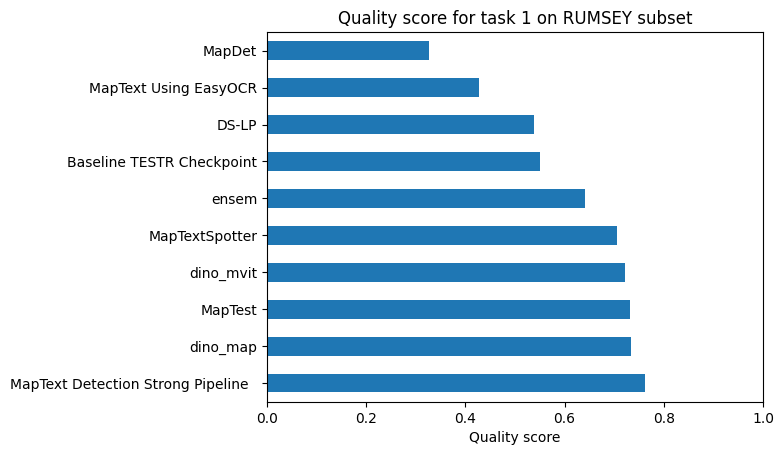

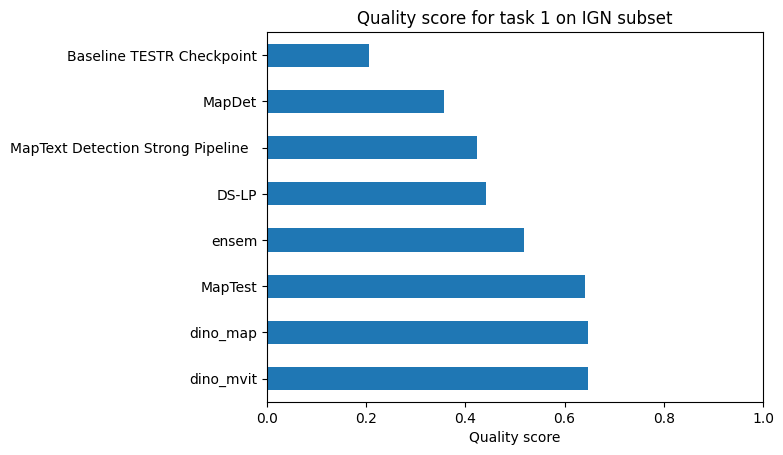

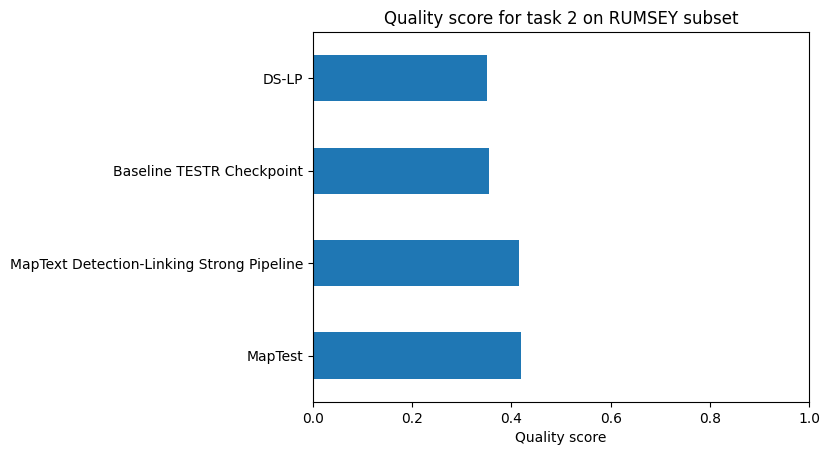

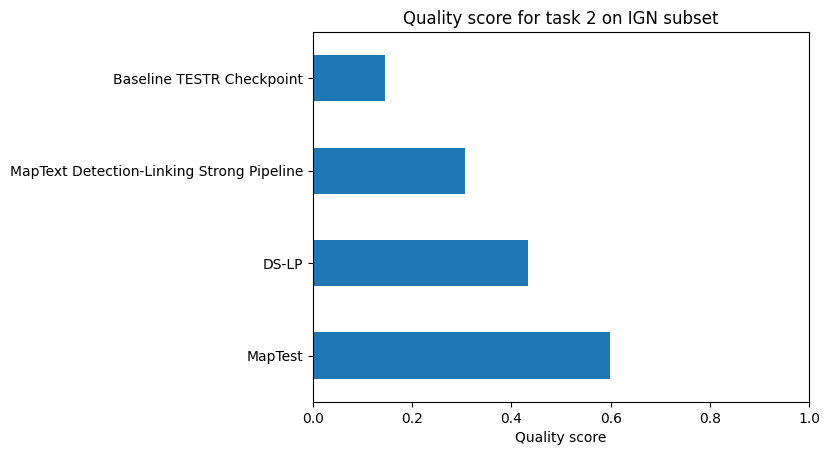

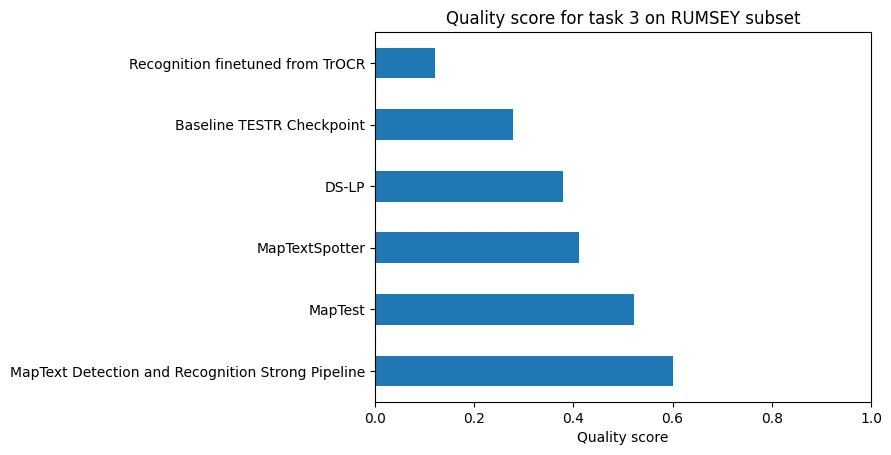

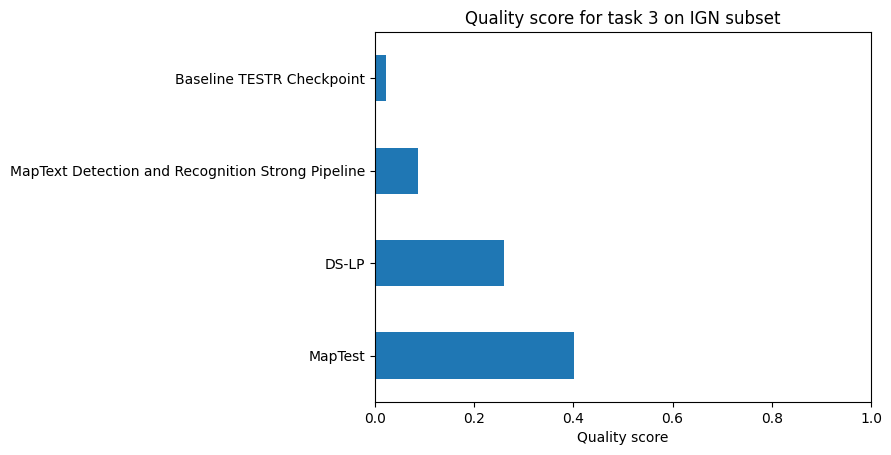

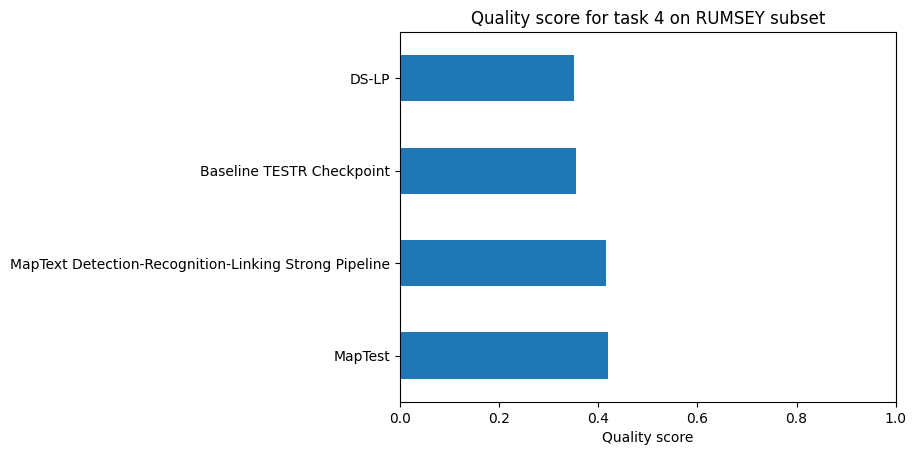

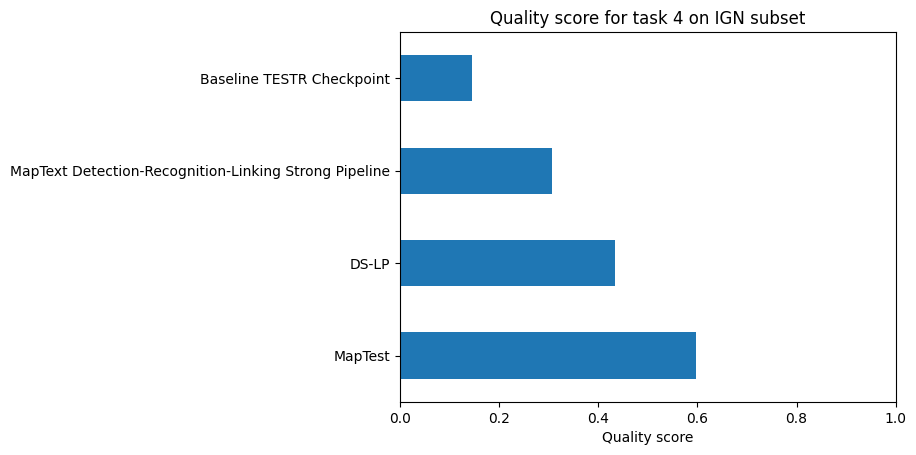

In [13]:
generate_all_tables_and_plot()